### given a path + gt, output: img and pred_bboxes, (optional) loss at this image

In [ ]:
# todo: try to rewrite predict_and_save so that it can also output the predictions for TBoard
# or simply print those in console while training

In [19]:
# def img_for_TBoard(path):

# import random
# random.randint(0, 12880)

import os
import json
import cv2
import numpy as np

import torch

from utils import letterbox_pad, scale_numbers, objectness_filter_and_nms
from darknet import Darknet

cfg_path = './cfg/yolov3_608x608_faces_only.cfg'
model_width = 608
device = torch.device('cuda:0')
model = Darknet(cfg_path).to(device)

with open('./data/train.json', 'r') as fread:
    train_meta = json.load(fread)

path = train_meta['3525']['full_file_path']
gt_bboxes = train_meta['3525']['gt_bboxes']

img_raw = cv2.imread(path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

H, W, C = img_raw.shape
H_new, W_new, scale = scale_numbers(H, W, model.model_width)
img = cv2.resize(img_raw, (W_new, H_new))
img, pad_sizes = letterbox_pad(img)

img = img.transpose((2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
img = img.to(device)

# make prediction
prediction = model(img, device=device)
print(prediction.shape)
# and apply objectness filtering and nms. If returns None, draw a box that states it
prediction = objectness_filter_and_nms(prediction, model.classes) # todo check whether it has batch dim

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot
torch.Size([1, 22743, 6])


/home/esa/miniconda3/envs/proj/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [8]:
import random

random.randint(0, 12880)

3525

### Playing with differentiation

In [2]:
import torch

x = torch.tensor(([2.]), requires_grad=True)
y = x**2
z = 2*y
w= z**3
w.backward()
x.grad

tensor([1536.])

$ dw/dz = 3z dz/dy$

$w = (2* x^2)^3 $

$dw/dx = 3*(z)^2 * dz/dx = (3*(z)^2) * (2) * dy/dx = (3*(z)^2) * (2) * (2x) dx/dx |_{x=1} $

$ 2 * 2 * 3*(2)^2 = 48 $


$dw/dx = 3*(z)^2 * dz/dx = (3*(z)^2) * (2) * dy/dx = (3*(z)^2) * (2) * (2x) dx/dx |_{x=2} $

$ 3*(2*4)^2 * 2 * 4 = 1536 $

In [14]:
import torch

x = torch.ones((2, 3, 7, 7, 5), requires_grad=True)
p_wh = torch.ones((1, 3, 1, 1, 2)) * 0.5

t_wh = x[:, :, :, :, 2:4]

predictions = x.clone().detach()
print(t_wh.sum())
predictions[:, :, :, :, 2:4] = (p_wh * torch.exp(t_wh)) * 4
print(t_wh.sum())

y = t_wh.sum()

y.backward()
# x.grad

tensor(588., grad_fn=<SumBackward0>)
tensor(588., grad_fn=<SumBackward0>)


### Build targets

In [1]:
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf


import torch

from utils import iou_vectorized

import numpy as np
from darknet import Darknet


anchors = torch.tensor([
    [ 3.6250,  2.8125],
    [ 4.8750,  6.1875],
    [11.6562, 10.1875]
]).float()

ignore_thresh = 0.5
B = 3
H, W = 13, 13
classes = 80
P = len(anchors) * (H * W)
device = torch.device('cpu')
num_anchs = len(anchors)

targets = torch.tensor([
    [ 0.0000, 37.0000,  0.3425,  0.7006,  0.2527,  0.0898],
    [ 0.0000,  0.0000,  0.4857,  0.4737,  0.6151,  0.4413],
    [ 1.0000, 62.0000,  0.6833,  0.2446,  0.4339,  0.1869],
    [ 1.0000, 14.0000,  0.7664,  0.5047,  0.1376,  0.1346],
    [ 1.0000, 57.0000,  0.1318,  0.3852,  0.2636,  0.4733],
    [ 1.0000,  0.0000,  0.4073,  0.5028,  0.4478,  0.6808],
    [ 1.0000,  0.0000,  0.4967,  0.5625,  0.2727,  0.3840],
    [ 2.0000, 10.0000,  0.2710,  0.6109,  0.4810,  0.5519],
    [ 2.0000,  0.0000,  0.6921,  0.4621,  0.5748,  0.6939]
]).float()

seed = np.random.RandomState(13)

x = torch.tensor(seed.rand(B, len(anchors), H, W, classes + 5)).float()
darknet = Darknet('./cfg/yolov3_608x608.cfg')
a = darknet.make_targets(x, targets, anchors, ignore_thresh, device)

# reshape tensors so that it is easier to use them in building targets
# x = x.view(B, W, H, num_anchs, classes + 5)
# x = x.permute(0, 3, 1, 2, 4).contiguous() # -> (B, A, w, h, 5+classes)
b = build_targets(x[..., :4], x[..., 5:], targets, anchors, ignore_thresh);

print('should be 0: ', ((b[0] - a[0]) > 1e-6).sum())
print('should be 0: ', ((b[1] - a[1]) > 1e-6).sum())
print('should be 0: ', ((b[2] - a[2]) > 1e-6).sum())
print('should be 0: ', ((b[3] - a[3]) > 1e-6).sum())
print('should be 0: ', ((b[4] - a[4]) > 1e-6).sum())
print('should be 0: ', ((b[5] - a[5]) > 1e-6).sum())
print('should be 0: ', ((b[6] - a[6]) > 1e-6).sum())
print('should be 0: ', ((b[7] - a[7]) > 1e-6).sum())
print('should be 0: ', ((b[8] - a[8]) > 1e-6).sum())
print('should be 0: ', ((b[9] - a[9]) > 1e-6).sum())

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot
> /home/esa/ActNet/PersonalProjects/experiments/detector/yolo/darknet.py(630)make_targets()
    628         best_ious, best_anchors = gt_anchor_ious.max(dim=0)
    629         set_trace()
--> 630         cx, cy = cxy.t()
    631         bw, bh = bwh.t()
    632         # remove a decimal part -> grid_i, grid_j point to the top left coord



ipdb>  bwh.t().shape


torch.Size([2, 9])


ipdb>  q


BdbQuit: 

### check the IoU calculation

In [3]:
import torch
from utils import iou_vectorized
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area

    return inter_area / union_area

bwh = torch.tensor([[7.8488, 8.5067],
        [7.5321, 4.8977],
        [8.4885, 8.3104],
        [1.9578, 1.7274],
        [1.0205, 0.4945],
        [3.6770, 2.3804],
        [5.4157, 5.6601],
        [2.4083, 4.3674],
        [4.9475, 5.2731],
        [5.2778, 3.9890],
        [2.8572, 4.6735]])

anchors = torch.tensor([[ 3.6250,  2.8125],
        [ 4.8750,  6.1875],
        [11.6562, 10.1875]])

print(iou_vectorized(anchors, bwh, without_center_coords=True))
print(torch.stack([bbox_wh_iou(anchor, bwh) for anchor in anchors]))

tensor([[0.1527, 0.2764, 0.1445, 0.3317, 0.0495, 0.8362, 0.3326, 0.4859, 0.3908,
         0.4843, 0.5180],
        [0.4518, 0.5530, 0.4276, 0.1121, 0.0167, 0.2902, 0.8305, 0.3487, 0.8416,
         0.6121, 0.4427],
        [0.5623, 0.3107, 0.5941, 0.0285, 0.0042, 0.0737, 0.2581, 0.0886, 0.2197,
         0.1773, 0.1124]])
tensor([[0.1527, 0.2764, 0.1445, 0.3317, 0.0495, 0.8362, 0.3326, 0.4859, 0.3908,
         0.4843, 0.5180],
        [0.4518, 0.5530, 0.4276, 0.1121, 0.0167, 0.2902, 0.8305, 0.3487, 0.8416,
         0.6121, 0.4427],
        [0.5623, 0.3107, 0.5941, 0.0285, 0.0042, 0.0737, 0.2581, 0.0886, 0.2197,
         0.1773, 0.1124]])


### Prediction permutations <->

In [1]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

## Forward
# transform the predictions
# (B, ((4+1+classes)*num_achors), Gi, Gi)
# -> (B, Gi*Gi*num_anchors, (4+1+classes), Gi, Gi)
x = x.view(B, num_anchs, num_feats, w, h)
x = x.permute(0, 3, 4, 1, 2).contiguous() # (B, w, h, num_anchs, num_feats)
x = x.view(B, h*w*num_anchs, num_feats)

## Backward
x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 4, 1, 2).contiguous()
x = x.view(B, num_feats*num_anchs, w, h)

prediction = (
    x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
    .permute(0, 1, 3, 4, 2) # (B, A, G, G, C)
    .contiguous()
)

(x - torch.arange(0, C*w*h).view((B, C, w, h))).sum()

tensor(0)

In [1]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 4, 1, 2).contiguous() # -> (B, A, 5+classes, w, h)
x = x.view(B, num_feats*num_anchs, w, h) # ->  (B, A*(5+classes), w, h)
x = x.view(B, num_anchs, num_feats, w, h)
x = x.permute(0, 1, 3, 4, 2).contiguous()

a = x

In [2]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 1, 2, 4).contiguous()

b = x

In [3]:
(a != b).sum()

tensor(0)

In [4]:
import torch

a = torch.rand((2, 4, 6, 2))
print(a.shape)
a[:, :, :, 0].shape

torch.Size([2, 4, 6, 2])


torch.Size([2, 4, 6])

### get predictions + show

In [4]:
from matplotlib import pyplot as plt
import cv2
import torch

from darknet import Darknet
from utils import predict_and_save, scale_numbers, letterbox_pad

model = Darknet('./cfg/yolov3_608x608.cfg')
weight_file = './weights/yolov3.weights'
model.load_weights(weight_file)
model.eval();

device = torch.device('cpu')
labels_path='./data/coco.names'
# img_path = 'dog-cycle-car.png'
img_path = 'databreakfast_spb.jpg'
# img_path = 'typical_russian_morning.jpg'
save_path = './output.jpg'
show = True

img_raw = cv2.imread(img_path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

# add letterbox padding and save the pad sizes and scalling coefficient
# to use it latter when drawing bboxes on the original image
H, W, C = img_raw.shape
H_new, W_new, scale = scale_numbers(H, W, model.model_width)
img = cv2.resize(img_raw, (W_new, H_new))
img, pad_sizes = letterbox_pad(img)

# HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
img = img.transpose((2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)

prediction = model(img, device=device)
# (76 x 76 + 38 x 38 + 19 x 19) * 3 = 22743

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot


/home/esa/miniconda3/envs/p37_c10/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


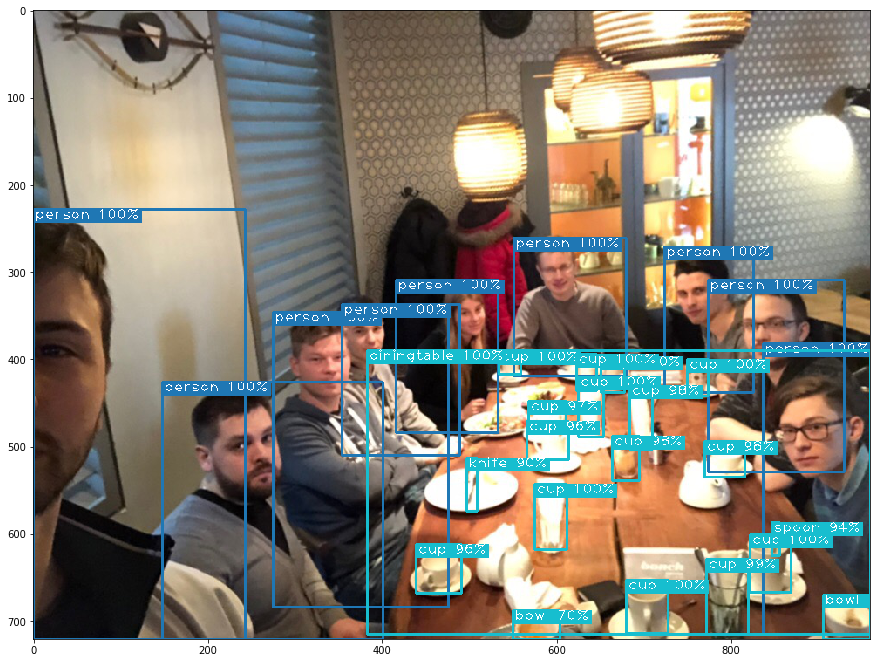

In [5]:
prediction = predict_and_save(img_path, save_path, model, device, labels_path, show)